## 1. Import Library
___

**Install EfficientDet Library**

In [1]:
!pip install -q git+https://github.com/rwightman/efficientdet-pytorch

  Preparing metadata (setup.py) ... done


**Install tf-efficientnet Library**

In [2]:
!pip install -q efficientnet

from efficientnet.keras import preprocess_input

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.6 MB/s eta 0:00:00


In [3]:
import os 
import sys
import pickle
import random
import gc
import ctypes
import copy
from collections import defaultdict

from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore
from PIL import Image
import cv2

import torch; import timm
print(f'{Fore.BLUE} => Pytorch Version: ', torch.__version__)
print(f'{Fore.BLUE} => Timm Version: ', timm.__version__)
import torch.nn as nn
from torch.cuda import amp
import torch.functional as F
from torch.utils.data import DataLoader, Dataset

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

## EfficientDet Library
from effdet.efficientdet import EfficientDet, HeadNet, BiFpn
from effdet.bench import DetBenchTrain, DetBenchPredict
# default config: tf_efficientdet_d1
from effdet.config import get_efficientdet_config, default_detection_model_configs
from effdet.config import default_detection_train_config, get_fpn_config

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
import warnings
warnings.filterwarnings('ignore')

print(f'{Fore.BLUE} => Installed Necessary Library')

 => Pytorch Version:  2.5.1+cu121
 => Timm Version:  1.0.12


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.3 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


 => Installed Necessary Library


### Configuration

In [4]:
class CFG:
    output_dir = 'runs/predict'
    seed = 2025

    img_size = [256, 256]
    imgdir = '/kaggle/input/gastroscopy-256x256-resized-png'
    model_name = 'tf_efficientdet_d0'
    pretrained_model = '/kaggle/input/gastroscopy-effdet/runs/detect/best-checkpoint.bin'
    num_classes = 3 # Ulcer, Polyp, Cancer
    batch_size = 32
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device_count = torch.cuda.device_count()

print('Device is', CFG.device)
print('Num GPU of machine is', CFG.device_count)

Device is cuda
Num GPU of machine is 1


### Reproducibility

In [5]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(CFG.seed)

### Clean_memory

In [6]:
def clean_memory():
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()

clean_memory()

## 2. Build Dataset
___

In [7]:
df = pd.read_csv('/kaggle/input/gastroscopy-meta/gastroscopy_data2.csv')
print('Shape of DataFrame: ', df.shape)
print(display(df))

Shape of DataFrame:  (2915, 14)


,image_id,height,width,organ,lesion_label,location,shape_type_polygon,polygon_mask,bounding_box_shape,x_min,y_min,x_max,y_max,lesion
0,1_1_00011.png,2048,2048,gastroscopy,0,1,polygon,"1257.45,738.30;1212.77,748.94;1168.09,748.94;1...",rectangle,763.829787,365.957447,1304.255319,748.936170,ulcer
1,1_1_00011.png,2048,2048,gastroscopy,0,1,polygon,"1421.28,955.32;1387.23,985.11;1368.09,1025.53;...",rectangle,1148.936170,897.872340,1421.276596,1082.978723,ulcer
2,1_1_00014.png,2048,2048,gastroscopy,0,1,polygon,"1065.96,1110.64;1040.43,1148.94;1010.64,1182.9...",rectangle,521.276596,561.702128,1078.723404,1225.531915,ulcer
3,1_1_00017.png,2048,2048,gastroscopy,0,1,polygon,"1246.30,514.89;1197.36,508.51;1154.81,502.13;1...",rectangle,884.595745,502.127660,1376.085106,753.191489,ulcer
4,1_1_00018.png,2048,2048,gastroscopy,0,1,polygon,"1397.36,389.36;1352.68,382.98;1314.38,404.26;1...",rectangle,1161.191489,382.978723,1654.808511,1074.468085,ulcer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2910,1_2_05234.png,2048,2048,gastroscopy,1,1,polygon,"1115.23,604.26;1066.30,604.26;1021.62,608.51;9...",rectangle,864.170213,604.255319,1506.723404,1340.425532,polyp
2911,1_2_05235.png,2048,2048,gastroscopy,1,1,polygon,"1138.64,1036.17;1096.09,1068.09;1064.17,1102.1...",rectangle,949.276596,1019.148936,1528.000000,1542.553191,polyp
2912,1_2_05236.png,2048,2048,gastroscopy,1,1,polygon,"619.49,529.79;583.32,555.32;553.53,591.49;532....",rectangle,523.744681,519.148936,766.297872,789.361702,polyp
2913,1_2_05236.png,2048,2048,gastroscopy,1,1,polygon,"672.68,1342.55;630.13,1355.32;606.72,1393.62;6...",rectangle,602.468085,1342.553191,759.914894,1493.617021,polyp


None


In [8]:
df['lesion_label'] = df['lesion_label'] + 1

In [9]:
test_id = [x.split('/')[-1] for x in glob('/kaggle/input/gastroscopy-256x256-resized-png/test/*.png')] 

test_df = df[df['image_id'].isin(test_id)].reset_index(drop=True)

print('=> Number of Unique Image_id in Test: ', test_df.image_id.nunique())

=> Number of Unique Image_id in Test:  400


In [10]:
class Test_GastroscopyDataset(Dataset):
    def __init__(self, df, image_dir=None):
        super(Test_GastroscopyDataset).__init__()
        self.image_ids = df['image_id'].unique()
        self.df = df
        self.image_dir = image_dir

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, index):
        image_id = self.image_ids[index]
        path = os.path.join(f'{self.image_dir}', 'test', image_id)
        image = Image.open(path).resize((CFG.img_size[0],CFG.img_size[1]))
        image = np.array(image)

        ## FillNan
        m = np.nanmean(image)
        image = np.nan_to_num(image, nan=m)

        image = preprocess_input(image)
        image = torch.tensor(image.transpose(2,0,1).astype(np.float32))

        return image, image_id
        

In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [12]:
test_dataset = Test_GastroscopyDataset(
    df = test_df,
    image_dir = CFG.imgdir
)

test_loader = DataLoader(
    test_dataset,
    batch_size = CFG.batch_size,
    shuffle = False,
    collate_fn = collate_fn
)

## 3. Inference
___

In [13]:
def load_net(checkpoint_path):
    config = get_efficientdet_config(model_name=CFG.model_name)
    config.num_classes = CFG.num_classes
    config.image_size = CFG.img_size
    config.max_det_per_image = 100

    net = EfficientDet(config, pretrained_backbone=False)
    net.box_net = HeadNet(config, num_outputs=4)
    net.class_net= HeadNet(config, num_outputs=config.num_classes)
    
    net.load_state_dict(torch.load(checkpoint_path))
    
    net = DetBenchPredict(net)

    return net

In [14]:
def format_pred(boxes, scores, labels):
    pred_strings = []
    for label, score, bbox in zip(labels, scores, boxes):
        xmin, ymin, xmax, ymax = bbox.astype(np.float32)
        pred_strings.append(f"{label} {score} {xmin} {ymin} {xmax} {ymax}")
    return " ".join(pred_strings)

In [15]:
def string_decoder(predict_string):
    s = predict_string.split(' ')
    class_id = [x for x in (s[0::6])]
    score = [x for x in (s[1::6])]
    x_min = [x for x in (s[2::6])]
    y_min = [x for x in (s[3::6])]
    x_max = [x for x in (s[4::6])]
    y_max = [x for x in (s[5::6])]

    return class_id, score, x_min, y_min, x_max, y_max

**Box Format**

1) EfficientDet의 학습 bbox format: `ymin, xmin, ymax, xmax`

2) EfficientDet의 출력 bbox format: `xmin, ymin, xmin, ymin`

In [16]:
def make_predictions(images, score_threshold=0.0):
    images = torch.stack(images).to(CFG.device).float()
    
    net = load_net(CFG.pretrained_model)
    net.to(CFG.device)
    net.eval()

    img_info = {}
    img_info['img_scale'] = torch.tensor([1] * images.shape[0], dtype=torch.float).to(CFG.device)
    img_info['img_size'] = torch.tensor([images[0].shape[-2:]] * images.shape[0], dtype=torch.float).to(CFG.device)

    predictions = []
    with torch.no_grad():
        
        det = net(images, img_info)
        for i in range(images.shape[0]):
            boxes = det[i].cpu().numpy()[:,:4]
            scores = det[i].cpu().numpy()[:,4]
            labels = det[i].cpu().numpy()[:,5].astype('int32')
            
            indexes = np.where(scores >= score_threshold)
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
                'labels': labels[indexes],
            })
    return predictions    

In [17]:
results = []

for images, image_ids in tqdm(test_loader, total=len(test_loader)):
    predictions = make_predictions(images)
    for i, image in enumerate(images):
        boxes = predictions[i]['boxes']
        scores = predictions[i]['scores']
        labels = predictions[i]['labels'] - 1
        image_id = image_ids[i]

        result = {
             'image_id': image_id,
             'PredictionString': format_pred(boxes, scores, labels)
                 }
        results.append(result)

100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


In [18]:
submission_det = pd.DataFrame(results, columns=['image_id','PredictionString'])
submission_det.to_csv('/kaggle/working/submission.csv', index=False)
print(display(submission_det))

,image_id,PredictionString
0,1_1_00030.png,2 0.398549884557724 107.38351440429688 139.439...
1,1_1_00033.png,2 0.2059495896100998 66.18744659423828 124.330...
2,1_1_00035.png,1 0.25049343705177307 115.7499771118164 127.61...
3,1_1_00040.png,1 0.30029672384262085 69.27588653564453 137.55...
4,1_1_00095.png,0 0.412151962518692 85.11062622070312 55.08928...
...,...,...
395,1_2_05208.png,1 0.39030736684799194 75.84912109375 113.27760...
396,1_2_05210.png,2 0.4465336501598358 53.10492706298828 94.2211...
397,1_2_05211.png,1 0.34620052576065063 9.22224235534668 132.200...
398,1_2_05229.png,1 0.31401175260543823 73.71040344238281 141.49...


None


In [19]:
submission_list = []

for i, row in tqdm(submission_det.iterrows(), total=len(submission_det)):
    image_id = row['image_id']
    string_decoded = string_decoder(row['PredictionString'])

    for  (class_id, score, xmin, ymin, xmax, ymax) in zip(*string_decoded):
        submission_list.append(
            {
                'image_id': image_id,
                'lesion_label': int(class_id),
                'score': float(score),
                'x_min': float(xmin),
                'y_min': float(ymin),
                'x_max': float(xmax),
                'y_max': float(ymax),
                }
        )

submission_metric = pd.DataFrame(submission_list, columns=['image_id', 'lesion_label', 'score','x_min','y_min', 'x_max', 'y_max'])

100%|██████████| 400/400 [00:00<00:00, 2525.89it/s]


In [20]:
!pip install map-boxes
from map_boxes import mean_average_precision_for_boxes

Couldn't import fast version of function compute_overlap, will use slow one. Check cython intallation


In [21]:
ann = test_df.copy()
det = submission_metric.copy()

ann['lesion_label'] -=1
ann['x_min'] *= CFG.img_size[0]/ann['width'].values[0]; ann['x_max'] *= CFG.img_size[0]/ann['width'].values[0]
ann['y_min'] *= CFG.img_size[1]/ann['height'].values[0]; ann['y_max'] *= CFG.img_size[1]/ann['height'].values[0]


ann_array = ann[['image_id','lesion_label','x_min','x_max','y_min','y_max']].values

det_array = det[['image_id','lesion_label', 'score','x_min','x_max','y_min','y_max']].values

mean_ap_50, average_precisions_50 = mean_average_precision_for_boxes(ann_array, det_array, iou_threshold=0.5)
mean_ap_75, average_precisions_75 = mean_average_precision_for_boxes(ann_array, det_array, iou_threshold=0.75)

Number of files in annotations: 400
Number of files in predictions: 400
Unique classes: 3
Detections length: 400
Annotations length: 400
0                              | 0.335186 |     150
1                              | 0.167409 |     270
2                              | 0.694866 |     231
mAP: 0.399153
Number of files in annotations: 400
Number of files in predictions: 400
Unique classes: 3
Detections length: 400
Annotations length: 400
0                              | 0.092035 |     150
1                              | 0.020371 |     270
2                              | 0.304809 |     231
mAP: 0.139072


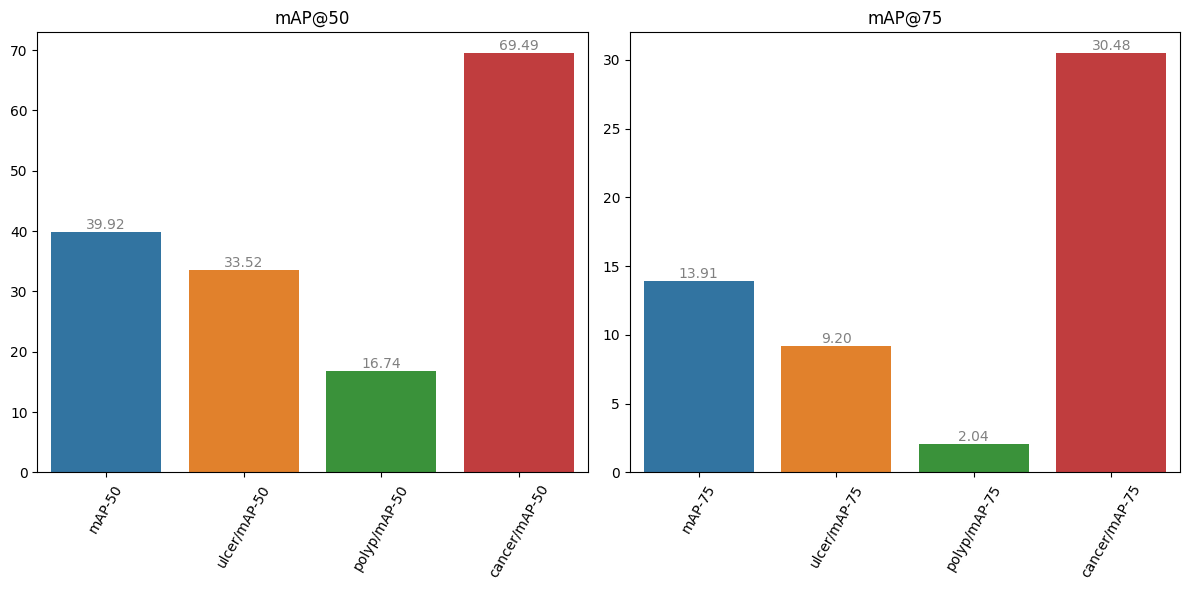

In [22]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title('mAP@50')
ax = sns.barplot(
    x=['mAP-50', 'ulcer/mAP-50', 'polyp/mAP-50', 'cancer/mAP-50'],
    y = [mean_ap_50*100, average_precisions_50['0'][0]*100,
              average_precisions_50['1'][0]*100, average_precisions_50['2'][0]*100],
    
)

for rect in ax.patches:
    x = rect.get_x() + rect.get_width() / 2.0  # 막대 중앙 x좌표
    y = rect.get_height()  # 막대 길이
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom', size=10, color='gray')  # 텍스트 위치 조정
plt.xticks(rotation=60)

plt.subplot(1,2,2)
plt.title('mAP@75')
ax = sns.barplot(
    x=['mAP-75', 'ulcer/mAP-75', 'polyp/mAP-75', 'cancer/mAP-75'],
    y = [mean_ap_75*100, average_precisions_75['0'][0]*100,
              average_precisions_75['1'][0]*100, average_precisions_75['2'][0]*100],
    
    
)

for rect in ax.patches:
    x = rect.get_x() + rect.get_width() / 2.0  # 막대 중앙 x좌표
    y = rect.get_height()  # 막대 길이
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom', size=10, color='gray')  # 텍스트 위치 조정

plt.xticks(rotation=60)

plt.tight_layout()
plt.show()

## 4. Display Predicted Image
___

In [23]:
def draw_bbox(image, box, label_name, label_id, color):
    alpha_text = 0.8 # text box color
    thickness = 2
    overlay_bbox = image.copy()
    overlay_text = image.copy()
    output = image.copy()

    text_width, text_height = cv2.getTextSize(str(label_id) + ' ' + label_name.upper(), cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)[0]
    # Adding Text Box
    cv2.rectangle(overlay_text, (box[0],box[1]-text_height-5),
                  (box[0]+text_width, box[1]), color, -1)
    cv2.addWeighted(overlay_text, alpha_text, output, 1-alpha_text, 0, output)
    cv2.rectangle(output, (box[0], box[1]), (box[2],box[3]), color, thickness)
    cv2.putText(output, str(label_id) + ' ' + label_name.upper(), (box[0], box[1]-3),
               cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)

    return output

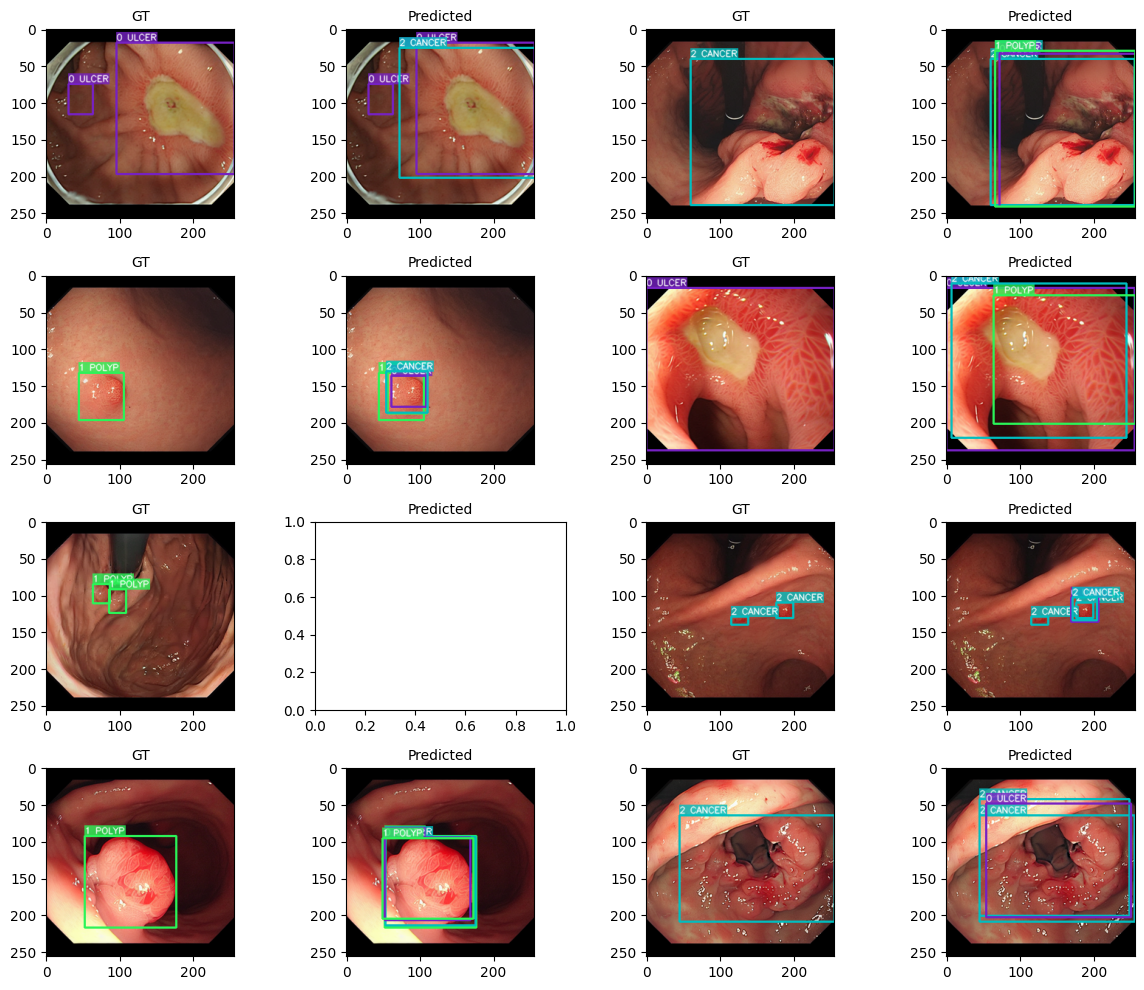

In [24]:
classes = {0: 'Ulcer', 1: 'Polyp', 2: 'Cancer'}
label2color = [[random.randint(0,255) for i in range(3)] for _ in range(CFG.num_classes)]
score_threshold = 0.2

plt.style.use('default')
plt.figure(figsize=(12,10))

for i in range(8):
    j = np.random.randint(0, len(test_dataset), 1)[0]
    image, image_id = test_dataset[j]
    img = image.permute(1,2,0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406]) 
    std = np.array([0.229, 0.224, 0.225])
    img = img*std + mean
    
    img = (img*255).astype('uint8')
    records = ann[ann['image_id'] == image_id]
    boxes = records[['x_min','y_min','x_max','y_max']].values
    labels = records['lesion_label'].values

    records = det[det['image_id'] == image_id]
    predicted_scores = records['score'].values
    indexes = np.where(predicted_scores >= score_threshold)
    predicted_boxes = records[['x_min','y_min', 'x_max','y_max']].values
    predicted_labels = records['lesion_label'].values
    predicted_boxes = predicted_boxes[indexes]; predicted_labels = predicted_labels[indexes]
        
    plt.subplot(4,4,2*i+1)
    plt.title('GT', size=10)
    for label_id, box in zip(labels, boxes):
        color = label2color[label_id - 1]
        img = draw_bbox(img, list(np.int_(box)), classes[label_id], label_id, color)
        plt.imshow(img)
        #plt.axis('off')

    plt.subplot(4,4,2*i+2)
    plt.title('Predicted', size=10)
    for label_id, box in zip(predicted_labels, predicted_boxes):
        color = label2color[label_id - 1]
        img = draw_bbox(img, list(np.int_(box)), classes[label_id], label_id, color)
        plt.imshow(img)
        #plt.axis('off')
    
    clean_memory()
    del image, image_id, records
        
plt.tight_layout()
plt.show()